In [1]:
from copy import deepcopy
import os
import pathlib
import sys
from typing import Any, Optional, Tuple, Type

In [2]:
import torch

In [3]:
sys.path.append(os.path.join(sys.path[0], '../../../'))

from endure.data.io import Reader
from endure.lsm.cost import EndureCost
from endure.lsm.solver import QLSMSolver, ClassicSolver
from endure.lsm.types import Policy, System, LSMDesign, STR_POLICY_DICT, LSMBounds, Workload
from endure.ltune.util import LTuneEvalUtil
from endure.ltune.model import LTuneModelBuilder
from jobs.bayesian_pipeline import BayesianPipeline

In [4]:
path = '/bo_data/models/ltune/qlsm/'
config = Reader.read_config(os.path.join(path, 'endure.toml'))

In [5]:
hidden_length = config["ltune"]["model"]["hidden_length"]
hidden_width = config["ltune"]["model"]["hidden_width"]
norm_layer: str = config["ltune"]["model"]["norm_layer"]
dropout: float = config["ltune"]["model"]["dropout"]
categorical_mode: str = config["ltune"]["model"]["categorical_mode"]
bounds = LSMBounds()
size_ratio_range: Tuple[int, int] = (bounds.size_ratio_range[0], bounds.size_ratio_range[1])
max_levels: int = bounds.max_considered_levels

design_type = config['lsm']['design']
policy = STR_POLICY_DICT.get(design_type, Policy.Classic)

In [6]:
model = LTuneModelBuilder(hidden_length, hidden_width, norm_layer, dropout, categorical_mode, size_ratio_range, max_levels).build_model(policy)
cf = EndureCost(max_levels)

In [7]:
config["io"]["data_dir"]

'/bo_data'

In [8]:
design_type

'QFixed'

In [9]:
ltune_util = LTuneEvalUtil(config, model, design_type)

/home/anwesha/endurance/venv_endurance/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [10]:
bayesian_optimizer = BayesianPipeline(config)

In [11]:
# z0, z1, q, w = workload = ltune_util.gen._sample_workload(4)
# system = ltune_util.gen._sample_system()
# model.eval()
# with torch.no_grad():
#     out = ltune_util.get_ltune_out(system, z0, z1, q, w)
# ldesign = ltune_util.convert_ltune_output(out)
# lcost = cf.calc_cost(ldesign, system, z0, z1, q, w)

In [12]:
# wl = Workload(z0=z0, z1=z1, q=q, w=w)
# bo_design, bo_cost = bayesian_optimizer.run(system, wl)

In [17]:
import sqlite3
import numpy as np
import pandas as pd
import struct

import matplotlib.pyplot as plt


In [18]:
ls ../../../

classic_databases/           endure.py*          q_ei100_200_databases/
classic_ei100200_databases/  endure.toml         README.md
classic_ei3050_databases/    experiments/        requirements_botorch.txt
classic_qei2_3_databases/    jobs/               requirements.txt
classic_ucb_databases/       k_ei2_3_databases/  test/
design_comparison.csv        LICENSE             venv_endurance/
docker-compose.yaml          notebook/           yz_db_cost.db
Dockerfile                   pytest.ini          yz_ei100_200_databases/
endure/                      q_db_cost.db


In [19]:
con = sqlite3.connect("../../../classic_qei2_3_databases/classicqei23_databases/classic_qei_23db_cost.db")
cur = con.cursor()
delta_costs = []


runs = pd.read_sql_query('Select * from runs;', con)
run_ids = runs['run_id'].tolist()
for run_id in run_ids:
    cur.execute("""
        SELECT empty_reads, non_empty_reads, range_queries, writes FROM runs WHERE run_id = ?
        """, (run_id,))
    row = cur.fetchone()
    workload = Workload(*row)
    cur.execute("""
        SELECT physical_entries_per_page, range_selectivity, entries_per_page, total_elements, max_bits_per_element, read_write_asymmetry FROM runs WHERE run_id = ?
        """, (run_id,))
    row = cur.fetchone()
    system = System(*row)
    binary_data = system.E
    unpacked_data = struct.unpack('Q', binary_data)
    system.E = unpacked_data[0]

    print("System", system)
    model.eval()
    with torch.no_grad():
        out = ltune_util.get_ltune_out(system, workload.z0, workload.z1, workload.q, workload.w)
    ldesign = ltune_util.convert_ltune_output(out)
    lcost = cf.calc_cost(ldesign, system, workload.z0, workload.z1, workload.q, workload.w)
    cur.execute("""
        SELECT bayesian_cost FROM run_details WHERE run_id = ?
        """, (run_id,))
    bo_cost = cur.fetchone()
    delta_cost = (lcost - bo_cost[0]) / bo_cost[0] if bo_cost != 0 else 0
    delta_costs.append(delta_cost)
con.close()

System System(E=4096, s=2.1864852302417837e-08, B=8, N=982110623, H=18.454121875195042, phi=1.0)
System System(E=8192, s=3.129591995063093e-08, B=16, N=137778360, H=18.7619618222079, phi=1.0)
System System(E=2048, s=5.7386101145729965e-08, B=16, N=371854875, H=10.207221365992499, phi=1.0)
System System(E=2048, s=9.206079568824968e-09, B=32, N=745908013, H=16.801338765410613, phi=1.0)
System System(E=2048, s=5.147972454937298e-08, B=32, N=470724338, H=8.951967256298175, phi=1.0)
System System(E=8192, s=8.403125266084339e-09, B=4, N=700857393, H=17.352213432315658, phi=1.0)
System System(E=8192, s=4.902335793852868e-09, B=16, N=472977082, H=8.266894926131423, phi=1.0)
System System(E=1024, s=8.74426500477801e-08, B=32, N=249342051, H=12.800724305384376, phi=1.0)
System System(E=2048, s=1.9159719297896704e-08, B=64, N=835689234, H=8.170262134453614, phi=1.0)
System System(E=2048, s=3.073832417108356e-08, B=32, N=168717852, H=14.234022361738155, phi=1.0)
System System(E=2048, s=9.435633842

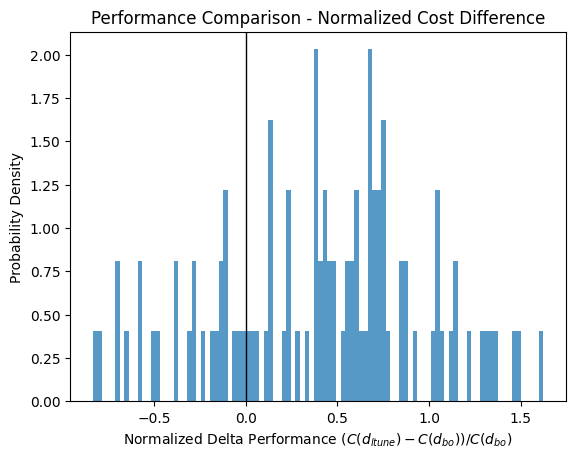

In [20]:
fig, ax = plt.subplots()
data = np.array(delta_costs)
ax.hist(data, bins=100, weights=np.ones_like(data) / len(data), alpha=0.75, density=True, color='tab:blue')
ax.set_ylabel('Probability Density')
ax.set_xlabel('Normalized Delta Performance $(C(d_{ltune}) - C(d_{bo})) / C(d_{bo})$')
ax.set_title('Performance Comparison - Normalized Cost Difference')
ax.axvline(x=0, color='black', linewidth=1)
plt.show()